# 다음에 볼 영화 예측하기

Movielens 1M Dataset 을 기반으로 Session Based Recommendation 시스템을 제작한다.
Session Based Recommendation은 말그대로 Session을 기반으로 한 추천시스템이다. Session이란 사용자의 로그 데이터 중 서버에 저장되는 값으로 쇼핑몰의 예로들면 유저정보, 아이템정보, 장바구니, 접속시간 등 유의미한 정보들이 있다. 이를 기반으로 사용자의 아이템 추천을 돕는다.


## Step 0. 라이브러리 및 데이터 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

data_path = 'data'
train_path = os.path.join(data_path, 'ratings.dat')

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## Step 1. 데이터의 전처리

In [2]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64


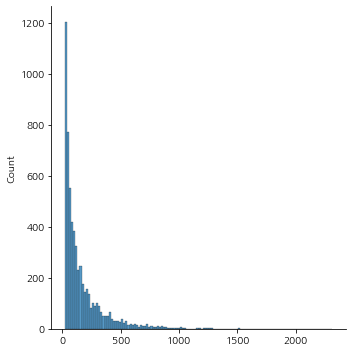

In [3]:
user_length = data.groupby('UserId').size()
print(user_length.describe())

_ = sns.displot(user_length)

In [4]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

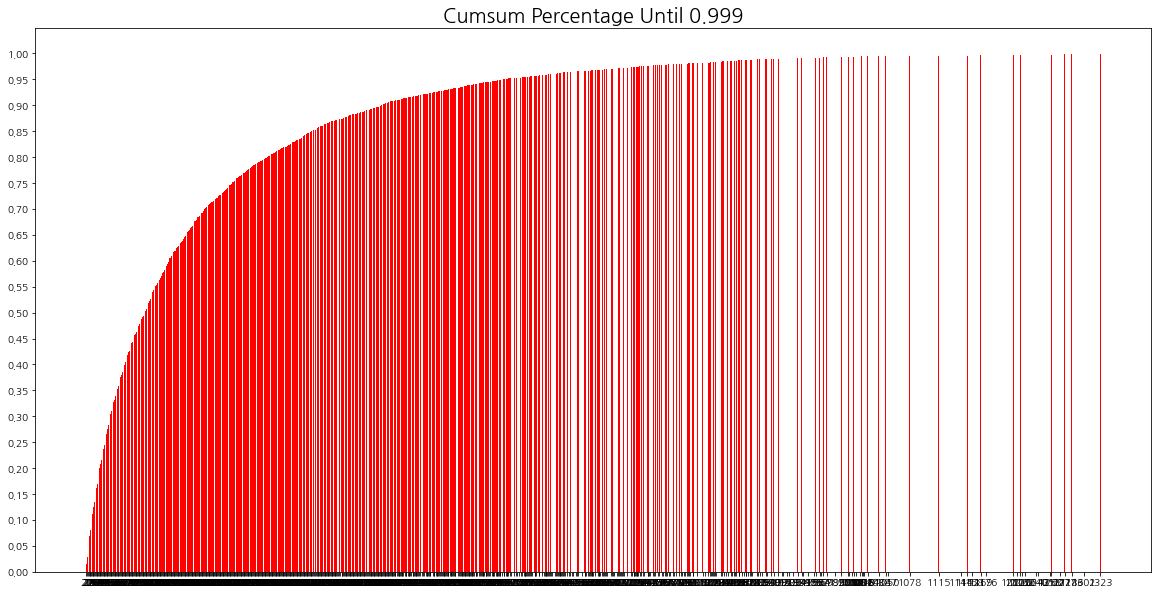

In [5]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [6]:
# 데이터의 시간정보
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [7]:
data['ItemId'].quantile(0.005), data['UserId'].quantile(0.005)

(7.0, 35.0)

In [8]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_user(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_user(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [9]:
before_len = len(data)
data = cleanse_recursive(data, shortest=2, least_click=8)
print(f"총 {before_len - len(data)}개의 데이터 제거")
data

총 1172개의 데이터 제거


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [10]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.sort_values(by=['Time'])
    user_in_train = user_last_time[user_last_time['Time']<=final_time-(n_days*24*3600)]
    user_in_test = user_last_time[user_last_time['Time']>final_time-(n_days*24*3600)]

    return user_in_train, user_in_test

In [11]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [12]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [13]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 988787
	 Users: 6039
	 Items: 3319
	 First Time : 956703932
	 Last Time : 1029160409

* valid Set Stats Info
	 Events: 5191
	 Users: 244
	 Items: 1932
	 First Time : 1029199206
	 Last Time : 1037810320

* test Set Stats Info
	 Events: 5059
	 Users: 254
	 Items: 1879
	 First Time : 1037824202
	 Last Time : 1046454590



In [14]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

## Step 2. 미니 배치의 구성

In [15]:
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [16]:
tr_dataset = UserDataset(tr)
tr_dataset.df.head()

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,956703932,0
1000153,6040,2384,4,956703954,1
999873,6040,593,5,956703954,2
1000192,6040,2019,5,956703977,3
1000007,6040,1961,4,956703977,4


In [17]:
print(tr_dataset.click_offsets)
print(tr_dataset.session_idx)

[     0     53    182 ... 988323 988446 988787]
[   0    1    2 ... 6036 6037 6038]


In [18]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [19]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(5)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,956703932,0
1000153,6040,2384,4,956703954,1
999873,6040,593,5,956703954,2
1000192,6040,2019,5,956703977,3
1000007,6040,1961,4,956703977,4


In [20]:
iter_ex = iter(tr_data_loader)

In [21]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53 106 210]
Label Item Idx are :       [  1  54 177 211]
Previous Masked Input Idx are []


## Step 3. 모델 구성

Session Based Recommendation을 위해 GRU 모델을 사용한다. 이는 2015년에 발표된 [Session-based Recommendations with Recurrent Neural Networks](https://arxiv.org/abs/1511.06939)를 기반으로 하였음을 짐작할 수 있다.

In [22]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [23]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [24]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=10)

In [25]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3319)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1026300   
_________________________________________________________________
dropout (Dropout)            (64, 100)                 0         
_________________________________________________________________
dense (Dense)                (64, 3319)                335219    
Total params: 1,361,519
Trainable params: 1,361,519
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습

In [26]:
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)
    
    history = {
        "train_loss": [],
        "train_acc": []
    }
    
    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        history['train_loss'].append(result[0])
        history['train_acc'].append(result[1])
        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
    return history

def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [27]:
history = train_model(model, args)

Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0, train_loss=6.7]      

	 - Recall@10 epoch 1: 0.046402
	 - MRR@10    epoch 1: 0.014527



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.53]

	 - Recall@10 epoch 2: 0.055871
	 - MRR@10    epoch 2: 0.017076



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.04]

	 - Recall@10 epoch 3: 0.058239
	 - MRR@10    epoch 3: 0.017897



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.07]

	 - Recall@10 epoch 4: 0.056345
	 - MRR@10    epoch 4: 0.018655



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.4] 

	 - Recall@10 epoch 5: 0.056818
	 - MRR@10    epoch 5: 0.018992



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.37]

	 - Recall@10 epoch 6: 0.056818
	 - MRR@10    epoch 6: 0.019510



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0, train_loss=6.41]     

	 - Recall@10 epoch 7: 0.059186
	 - MRR@10    epoch 7: 0.020380



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0781, train_loss=6.25]

	 - Recall@10 epoch 8: 0.055871
	 - MRR@10    epoch 8: 0.020982



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.99]

	 - Recall@10 epoch 9: 0.053504
	 - MRR@10    epoch 9: 0.021377



Evaluation:  43%|████▎     | 33/77 [00:08<00:10,  4.03it/s]

	 - Recall@10 epoch 10: 0.055398
	 - MRR@10    epoch 10: 0.022331



## Step 5. 모델 테스트

In [28]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  48%|████▊     | 36/75 [00:14<00:15,  2.57it/s]

	 - Recall@10: 0.149306
	 - MRR@10: 0.043705



[7.212370872497559, 7.103689193725586, 7.058794975280762, 6.994771957397461, 6.884220600128174, 6.824808120727539, 6.822902202606201, 6.78265380859375, 6.699895858764648, 6.659584045410156]
[0.03125, 0.015625, 0.03125, 0.03125, 0.015625, 0.015625, 0.015625, 0.0, 0.03125, 0.03125]


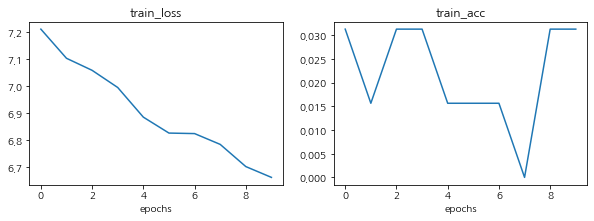

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['train_loss', 'train_acc']):
    ax[i].plot(history[met])
    print(history[met])
    ax[i].set_title(met)
    ax[i].set_xlabel('epochs')
plt.show()

## Step 5. 성능 개선을 위한 노력

1. GRU Units 수 변경
    1. 100 -> 128
    2. 100 -> 256
    3. 100 -> 64
2. Rating 점수에 따른 데이터 전처리
    1. Rating 1, 2의 데이턱 제거

1번의 경우 Args라는 클래스로 모델 구성의 argument들을 정의했기 때문에 Args를 수정함으로써 Hypter Parameter Tuning을 이룰 수 있다.<br/>
2번의 경우 Data 전처리부터 다시 불러와야 하는 부분들이 있다.

<br/>

**hsz parameter**

In [30]:
# GRU Model Hidden units size 100 -> 128
# GRU Model Hidden units size 100 -> 256
# GRU Model Hidden units size 100 -> 64

args = Args(tr, val, test, batch_size=64, hsz=128, drop_rate=0.1, lr=0.001, epochs=10, k=10)
model_hsz_128 = create_model(args)
args = Args(tr, val, test, batch_size=64, hsz=256, drop_rate=0.1, lr=0.001, epochs=10, k=10)
model_hsz_256 = create_model(args)
args = Args(tr, val, test, batch_size=64, hsz=64, drop_rate=0.1, lr=0.001, epochs=10, k=10)
model_hsz_64 = create_model(args)

history_128 = train_model(model_hsz_128, args)
history_256 = train_model(model_hsz_256, args)
history_64 = train_model(model_hsz_64, args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3319)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 128), (64, 128)]    1324416   
_________________________________________________________________
dropout_1 (Dropout)          (64, 128)                 0         
_________________________________________________________________
dense_1 (Dense)              (64, 3319)                428151    
Total params: 1,752,567
Trainable params: 1,752,567
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3319)]           0         
________________________________

Train:   0%|          | 0/15355 [00:00<?, ?it/s]

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3319)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 64), (64, 64)]      649920    
_________________________________________________________________
dropout_3 (Dropout)          (64, 64)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 3319)                215735    
Total params: 865,655
Trainable params: 865,655
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0, train_loss=6.68]     

	 - Recall@10 epoch 1: 0.046402
	 - MRR@10    epoch 1: 0.015434



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.56]

	 - Recall@10 epoch 2: 0.049242
	 - MRR@10    epoch 2: 0.017808



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.51]

	 - Recall@10 epoch 3: 0.051610
	 - MRR@10    epoch 3: 0.019829



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.44]

	 - Recall@10 epoch 4: 0.058239
	 - MRR@10    epoch 4: 0.020110



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.38]

	 - Recall@10 epoch 5: 0.060606
	 - MRR@10    epoch 5: 0.020861



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.29]

	 - Recall@10 epoch 6: 0.057292
	 - MRR@10    epoch 6: 0.021454



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.2] 

	 - Recall@10 epoch 7: 0.055398
	 - MRR@10    epoch 7: 0.020922



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.36]

	 - Recall@10 epoch 8: 0.053977
	 - MRR@10    epoch 8: 0.020704



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0, train_loss=6.36]     

	 - Recall@10 epoch 9: 0.055871
	 - MRR@10    epoch 9: 0.021777



Train:   0%|          | 0/15355 [00:00<?, ?it/s]

	 - Recall@10 epoch 10: 0.054451
	 - MRR@10    epoch 10: 0.020701



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.56]

	 - Recall@10 epoch 1: 0.055398
	 - MRR@10    epoch 1: 0.017670



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.45]

	 - Recall@10 epoch 2: 0.060606
	 - MRR@10    epoch 2: 0.022372



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.36]

	 - Recall@10 epoch 3: 0.058239
	 - MRR@10    epoch 3: 0.023445



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.91]

	 - Recall@10 epoch 4: 0.057765
	 - MRR@10    epoch 4: 0.022404



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.11]

	 - Recall@10 epoch 5: 0.053977
	 - MRR@10    epoch 5: 0.021082



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.96]

	 - Recall@10 epoch 6: 0.054451
	 - MRR@10    epoch 6: 0.019932



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.01]

	 - Recall@10 epoch 7: 0.050189
	 - MRR@10    epoch 7: 0.020934



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.92]

	 - Recall@10 epoch 8: 0.046875
	 - MRR@10    epoch 8: 0.019412



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.91]

	 - Recall@10 epoch 9: 0.052557
	 - MRR@10    epoch 9: 0.019490



Train:   0%|          | 0/15355 [00:00<?, ?it/s]

	 - Recall@10 epoch 10: 0.047348
	 - MRR@10    epoch 10: 0.018551



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0, train_loss=6.68]     

	 - Recall@10 epoch 1: 0.038826
	 - MRR@10    epoch 1: 0.012785



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0, train_loss=6.39]     

	 - Recall@10 epoch 2: 0.054924
	 - MRR@10    epoch 2: 0.017779



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.21]

	 - Recall@10 epoch 3: 0.055398
	 - MRR@10    epoch 3: 0.018585



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.14]

	 - Recall@10 epoch 4: 0.054924
	 - MRR@10    epoch 4: 0.018720



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.22]

	 - Recall@10 epoch 5: 0.058712
	 - MRR@10    epoch 5: 0.020310



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.12]

	 - Recall@10 epoch 6: 0.056345
	 - MRR@10    epoch 6: 0.021956



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.15]

	 - Recall@10 epoch 7: 0.054451
	 - MRR@10    epoch 7: 0.021747



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.18]

	 - Recall@10 epoch 8: 0.059186
	 - MRR@10    epoch 8: 0.022603



Train:   0%|          | 0/15355 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.18]

	 - Recall@10 epoch 9: 0.059659
	 - MRR@10    epoch 9: 0.022578



Evaluation:  43%|████▎     | 33/77 [00:08<00:11,  3.94it/s]

	 - Recall@10 epoch 10: 0.058712
	 - MRR@10    epoch 10: 0.021844



<br/>

**낮게 평가된 데이터 제거**

In [31]:
data = data[data["Rating"] >= 3]

tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

tr_dataset = UserDataset(tr)

tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)

args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=10)

model_rating_upper_3 = create_model(args)

history_upper_3 = train_model(model_rating_upper_3, args)

Train:   0%|          | 0/12832 [00:00<?, ?it/s]

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(64, 1, 3318)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1026000   
_________________________________________________________________
dropout_4 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_4 (Dense)              (64, 3318)                335118    
Total params: 1,361,118
Trainable params: 1,361,118
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/12832 [00:00<?, ?it/s, accuracy=0, train_loss=6.21]     

	 - Recall@10 epoch 1: 0.047991
	 - MRR@10    epoch 1: 0.014941



Train:   0%|          | 0/12832 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.89]

	 - Recall@10 epoch 2: 0.060268
	 - MRR@10    epoch 2: 0.020432



Train:   0%|          | 0/12832 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.01]

	 - Recall@10 epoch 3: 0.059152
	 - MRR@10    epoch 3: 0.021607



Train:   0%|          | 0/12832 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.72]

	 - Recall@10 epoch 4: 0.054688
	 - MRR@10    epoch 4: 0.021646



Train:   0%|          | 0/12832 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.72]

	 - Recall@10 epoch 5: 0.055246
	 - MRR@10    epoch 5: 0.020104



Train:   0%|          | 0/12832 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.74]

	 - Recall@10 epoch 6: 0.056362
	 - MRR@10    epoch 6: 0.019356



Train:   0%|          | 0/12832 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.69]

	 - Recall@10 epoch 7: 0.058594
	 - MRR@10    epoch 7: 0.021430



Train:   0%|          | 0/12832 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.63]

	 - Recall@10 epoch 8: 0.054129
	 - MRR@10    epoch 8: 0.020732



Train:   0%|          | 0/12832 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.64]

	 - Recall@10 epoch 9: 0.056920
	 - MRR@10    epoch 9: 0.020772



Evaluation:  44%|████▍     | 28/64 [00:07<00:09,  3.97it/s]

	 - Recall@10 epoch 10: 0.054129
	 - MRR@10    epoch 10: 0.020563



**결과 시각화하기**

In [32]:
def draw_history(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()
    plt.suptitle(title,fontsize=20)
    for i, met in enumerate(['train_loss', 'train_acc']):
        ax[i].plot(history[met])
        ax[i].set_title(met)
        ax[i].set_xlabel('epochs')
    plt.show()
    

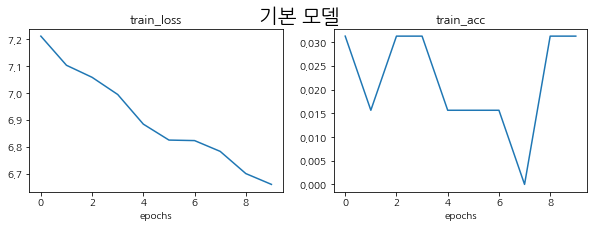

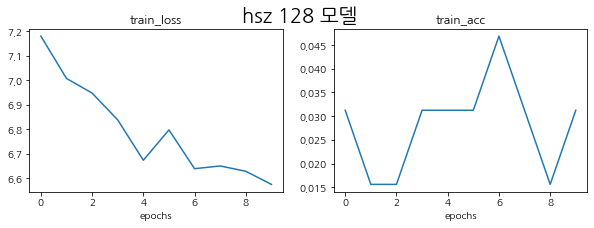

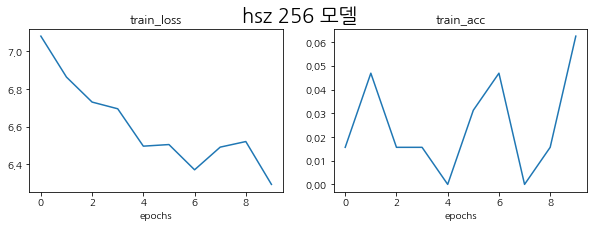

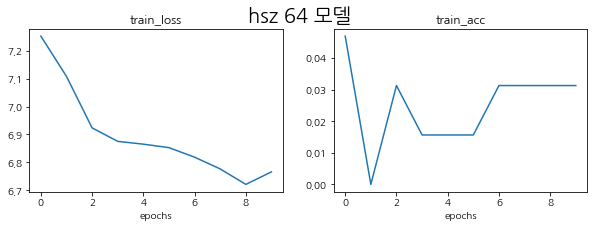

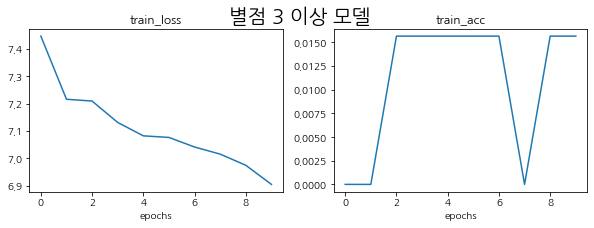

In [33]:
draw_history(history, "기본 모델")
draw_history(history_128, "hsz 128 모델")
draw_history(history_256, "hsz 256 모델")
draw_history(history_64, "hsz 64 모델")
draw_history(history_upper_3, "별점 3 이상 모델")

5가지 모델의 학습결과를 시각화했는데, Accuracy라는 평가지표가 어떠한 의미를 갖고있는지 잘 모르겠다. 그래서 안정적으로 학습 현황을 보여주는 Loss 만을 보게되면 기본모델에서 Loss가 가장 안정적으로 낮은값을 나타냄을 알 수 있다.